In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import plot_swps, get_sweeps, swp_window, get_protocol, files_from_protocol
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
import filtering
%matplotlib widget

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Synaptic/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 7',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9']

In [3]:
files = glob(folders[1]+"/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0008.abf']

In [4]:
get_protocol(files)

['Lab9_0_EvokedPSP', 'Lab8.1_gapfree', 'Lab8.1_gapfree', 'Lab9_0_EvokedPSP']

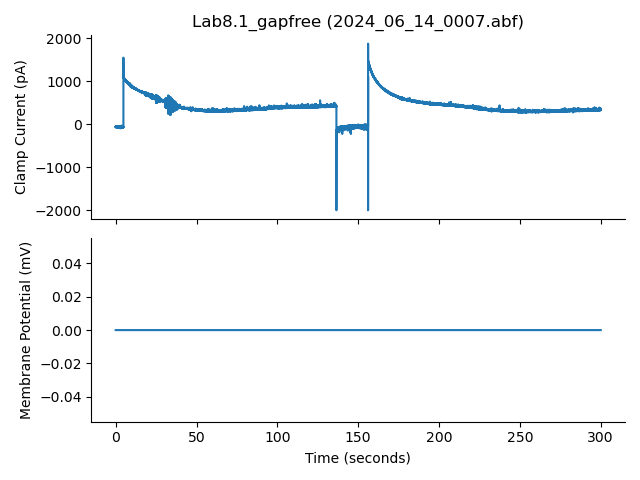

In [5]:
f = files[1]
plot_swps(f)

In [12]:
swps, swp_time, sr = get_sweeps(f)
zero = swp_window(swps,50,110,sr)[0]
zero -= np.mean(zero[:50])
zero_bis = swp_window(swps,200,300,sr)[0]
zero_bis -= np.mean(zero_bis[:50])

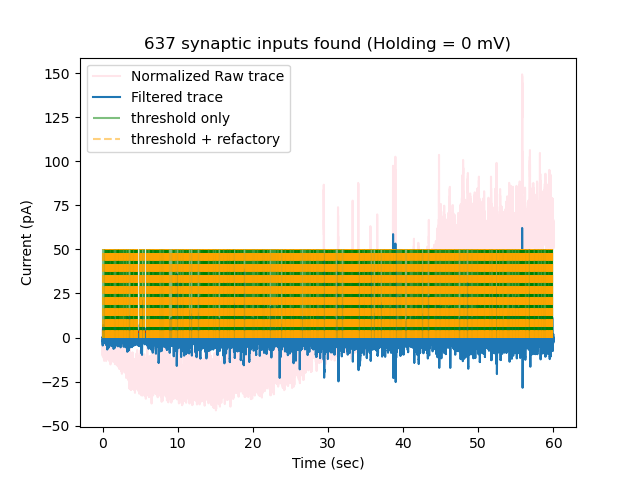

In [27]:
plt.close('all')
full_trace = zero
dt = 1/sr
full_filt = filtering.bandpass(full_trace, dt*1e3, 0.005,0.04)
thresh = 3
time = np.arange(len(full_trace))/sr
is_input = (full_filt[:-1]<thresh) * (full_filt[1:]>=thresh)
where_input = np.where(is_input)[0]
ref_t = 10e-3
refact = int(ref_t/dt)
ref = 0
where_syn = []
for i in where_input:
    if i<ref:
        continue
    else:
        syn = full_filt[i:i+refact]
    if syn.max() < thresh:
        continue
    else:
        where_syn.append(i)
        ref = i+refact
where_syn = np.array(where_syn)
fig,ax = plt.subplots()
ax.plot(time,full_trace,alpha=0.4,color='pink',label='Normalized Raw trace')
ax.plot(time,full_filt,label='Filtered trace')
ax.hlines(thresh,time[1],time[-1],alpha=0.7,color='red',linestyles='solid')
ax.vlines(where_input*dt,0,50,alpha=0.5,color='green',linestyles='solid')
ax.vlines(where_syn*dt,0,50,alpha=0.8,color='orange',linestyles='dashed')
#Legend
ax.vlines(0,0,0,alpha=0.5,color='green',linestyles='solid',label='threshold only')
ax.vlines(0,0,0,alpha=0.5,color='orange',linestyles='dashed',label='threshold + refactory')
ax.set_title(f'{len(where_syn)} synaptic inputs found (Holding = 0 mV)')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (sec)')
ax.legend()
plt.show()

In [28]:
where_syn

array([   942,   3437,   4083, ..., 597635, 598266, 598683])

Text(0, 0.5, 'Current (pA)')

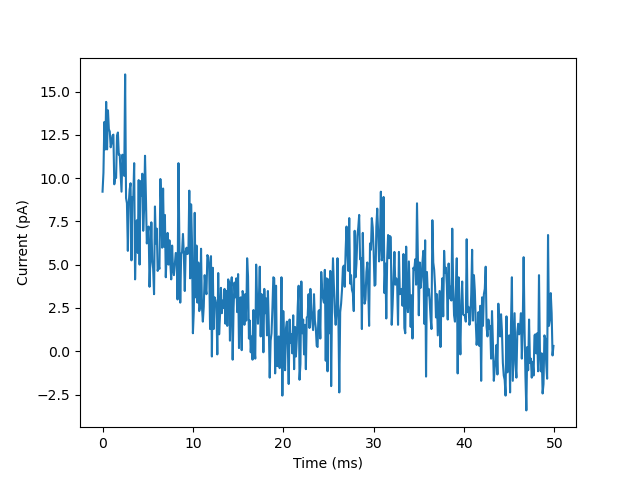

In [31]:
before = 2 # ms
after = 50 # ms
i_b = int(before*1e-3/dt)
i_a = int(after*1e-3/dt)
where_syn = where_syn[where_syn<(len(full_trace)-i_a)]
synaptic_input = np.array([full_trace[syn_i:syn_i+i_a]-np.mean(full_trace[syn_i-i_b])  
                           for syn_i in where_syn])

fig,ax = plt.subplots()
time = np.arange(len(synaptic_input[0]))/sr
ax.plot(time*1e3,synaptic_input[0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')